# Import files

In [1]:
# Files
import data_utils
import training_utils
import RandomAgent
import EpsilonGreedy
import UCB
import Thompson
import Exp3
import FairUCB

from data_utils import *
from training_utils import *
from RandomAgent import *
from EpsilonGreedy import *
from UCB import *
from Thompson import *
from Exp3 import *
from FairUCB import *

In [2]:
np.set_printoptions(threshold = np.inf)
plt.rcParams['figure.figsize'] = [15, 14]

# Dataset Utilities (Bandit Environment)

## An example dataset

Now let us illustrate what we did previously with a simple example and check that it's all working.
In the following, we generate 100 rows of data for a user with a clear preference: they like 100% of the content from group 1 and nothing from any other group (i.e, $p_1 = 1$ and $p_2 = 0$).

In [3]:
example = new_user(user_id = 0, n = 1000, n_arms = 5, print_stats = True)

--- Stats for user 0 : --- 

Group representation: 
 [[1.    0.196]
 [2.    0.206]
 [3.    0.209]
 [4.    0.202]
 [5.    0.187]]

 --------------------- 

Proportion of liked items inside each group: 
 [[1.         0.88265306]
 [2.         0.49029126]
 [3.         0.47368421]
 [4.         0.5049505 ]
 [5.         0.44385027]]

 --------------------- 

Proportion of all likes allocated to each group: 
 [[1.         0.31003584]
 [2.         0.18100358]
 [3.         0.17741935]
 [4.         0.1827957 ]
 [5.         0.14874552]]

 --------------------- 

User data: 
 [[0 2 1]
 [0 1 1]
 [0 4 1]
 [0 5 1]
 [0 2 0]
 [0 1 1]
 [0 3 1]
 [0 4 1]
 [0 1 1]
 [0 2 1]
 [0 1 1]
 [0 2 1]
 [0 1 1]
 [0 4 1]
 [0 4 0]
 [0 2 1]
 [0 4 1]
 [0 5 1]
 [0 2 1]
 [0 3 0]
 [0 1 1]
 [0 4 1]
 [0 2 1]
 [0 5 1]
 [0 4 0]
 [0 4 1]
 [0 1 1]
 [0 2 1]
 [0 2 0]
 [0 4 1]
 [0 4 1]
 [0 4 0]
 [0 1 1]
 [0 4 0]
 [0 2 1]
 [0 1 1]
 [0 3 1]
 [0 1 1]
 [0 2 0]
 [0 1 1]
 [0 4 0]
 [0 4 1]
 [0 1 1]
 [0 2 0]
 [0 3 1]
 [0 3 0]
 [0 5 0]
 [0 3 0

As expected, this user likes all items from group 10 and none from other groups.

# Training Utilities

Now that we have a dataset, we need to construct a simulation environment to use for training the bandit. In traditional machine learning, we build training/validation/test sets, where a model is trained and tuned on the training/validation sets and evaluated on the test set.

However, bandit algorithms are different in that they learn over time (*online*). At each time step, the bandit observes data from the past, updates its decision rule (called a *policy*), takes action by serving predictions based on this updated policy, and observes a reward value for this new action. The time component implies that the training data observed by the bandit is constantly changing, and that the score used to evaluate it is also changing over time based on small pieces of feedback from the most recent time step, rather than based on feedback from a large test set as is the case with traditional approaches.

The bandit’s recommendations will be different from those from our data generation model above. This implies several issues:
* First, the data is probably biased. An online learner requires a feedback loop where it presents an action, observes a user’s response, and then updates its policy accordingly. A historic dataset is going to be biased by the mechanism that generated it. The algorithm assumes that it generated the recommendation, but in reality, everything in the dataset was generated by a completely different model. A solution to this is to randomize the data generation process to create a dataset that’s independent and identically distributed, which we did at the beginning of this notebook.
* Second, the learning algorithm often generates recommendations that are different from the recommendations seen by users in the historic dataset. We can't supply a reward value for these recommendations because we don’t know what the user’s response would have been to something they never saw. We can only know how a user responded to what was supplied to them (i.e, the rows in the generated dataset). The solution to this is a method called **replay** [(Li et al., 2010)](https://arxiv.org/abs/1003.5956). Replay evaluation essentially takes the historic event stream and the algorithm’s recommendations at each time step, and throws out all samples except those where the model’s recommendation is the same as the one the user saw in the generated dataset. This proves to be an unbiased method for offline evaluation of an online learing algorithm.

# Bandit Algorithms

In this section, we implement 4 bandit algorithms:
* **$\epsilon$-greedy:** this algorithm follows a greedy policy, selecting the best-performing action (i.e, the one yielding the highest reward) at each time step. However, $\epsilon$% of the time, it goes off-policy and chooses an action at random. The value of $\epsilon$ determines how much the bandit should explore new actions as opposed to exploiting the ones that have performed the best historically up to now.
* **Upper Confidence Bound (UBC):** this algorithm constructs a confidence interval of what each action’s true reward might be, factoring in the uncertainty caused by variance in the data and the fact that we’re only able to observe a limited sample of trials for any given action. The algorithm then optimistically assumes that each action will perform as well as its upper confidence bound (UCB), selecting the one with the highest UCB.
* **Thompson Sampling:** this algorithm draws from the posterior predictive distributions of each choice using a random uniform variable. This allows a non-optimal distribution to be sampled with varying frequency — as the posterior distribution becomes more certain, the probability of the choice being made decreases dynamically; thus Thompson sampling adaptively balances the desire for more information with making the currently optimal choice.
* **Exp3:**

# Experiments

### Global parameters

In [4]:
# Size of each user dataset:
m = 10000

# Number of training rounds for each agent:
rounds = 5000

# Number of arms:
arms = 5

# Optimal agent parameters after tuning:
param_gamma      = 0.1 # Thompson Sampling
param_epsilon    = 0.1 # Epsilon-Greedy
param_multiplier = 1.0 # UCB

# 1. Baseline: Stochastic Bandits

# A. The Natural Setting (without polarization correction)

## First User: Random Preferences ($p_i = 0.5 \ \forall \ i$)

### Generate user data

In [5]:
user = new_user(1, n = m, n_arms = arms, preferences = [0.5, 0.5, 0.5, 0.5, 0.5], print_stats = True)

--- Stats for user 1 : --- 

Group representation: 
 [[1.     0.2079]
 [2.     0.2002]
 [3.     0.1986]
 [4.     0.1981]
 [5.     0.1952]]

 --------------------- 

Proportion of liked items inside each group: 
 [[1.         0.48869649]
 [2.         0.48201798]
 [3.         0.48640483]
 [4.         0.51741545]
 [5.         0.50973361]]

 --------------------- 

Proportion of all likes allocated to each group: 
 [[1.         0.20455003]
 [2.         0.19428226]
 [3.         0.19448359]
 [4.         0.20636199]
 [5.         0.20032213]]

 --------------------- 

User data: 
 [[1 5 0]
 [1 4 0]
 [1 1 1]
 [1 4 0]
 [1 5 0]
 [1 5 1]
 [1 3 0]
 [1 2 1]
 [1 2 1]
 [1 1 1]
 [1 4 1]
 [1 2 1]
 [1 4 1]
 [1 5 0]
 [1 1 0]
 [1 2 1]
 [1 1 0]
 [1 2 1]
 [1 1 0]
 [1 2 1]
 [1 2 1]
 [1 1 1]
 [1 5 0]
 [1 5 1]
 [1 3 0]
 [1 2 1]
 [1 4 1]
 [1 3 0]
 [1 3 0]
 [1 4 0]
 [1 5 0]
 [1 1 0]
 [1 4 0]
 [1 5 0]
 [1 1 0]
 [1 1 0]
 [1 2 0]
 [1 2 1]
 [1 2 0]
 [1 1 1]
 [1 2 1]
 [1 4 1]
 [1 1 1]
 [1 1 1]
 [1 5 1]
 [1 5 1]
 [1 5 

### Agents initialization and training

In [6]:
# Initialize agents
rdm  = RandomBandit()
eps  = EpsilonGreedy(epsilon = param_epsilon)
ucb  = UCB(bonus_multiplier = param_multiplier)
th   = Thompson()
exp3 = Exp3(gamma = param_gamma)

# Train agents
history_rdm  = train(user,  rdm, steps = rounds)
history_eps  = train(user,  eps, steps = rounds)
history_ucb  = train(user,  ucb, steps = rounds)
history_th   = train(user,   th, steps = rounds)
history_exp3 = train(user, exp3, steps = rounds)

----- Successfully trained Random Agent -----
----- Successfully trained Epsilon Greedy Agent -----
----- Successfully trained UCB Agent -----
----- Successfully trained Thompson Sampling Agent -----
----- Successfully trained Exp3 Agent -----


### Result plots

### Random agent

Group frequencies                 : [0.2034 0.1976 0.193  0.2066 0.1994]
Max gap between group frequencies : 0.013600000000000001


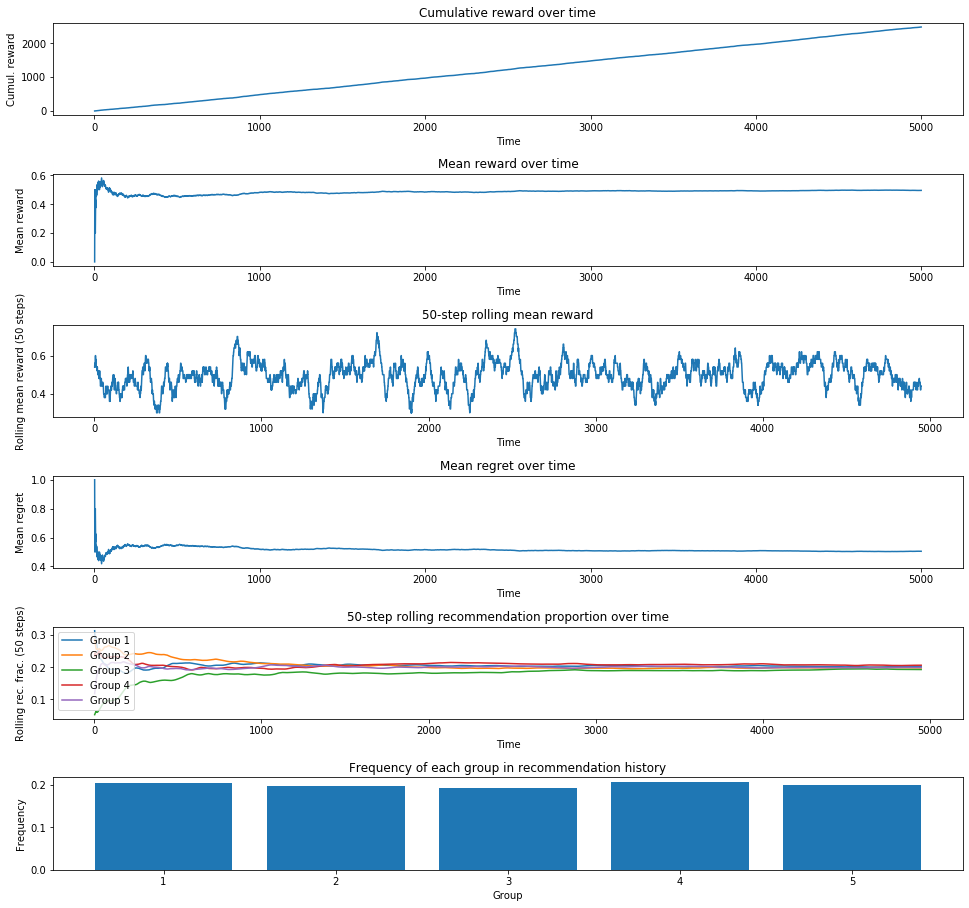

In [7]:
score(history_rdm, n_arms = arms)

### $\epsilon$-Greedy

Group frequencies                 : [0.509  0.0332 0.0214 0.0442 0.3922]
Max gap between group frequencies : 0.48760000000000003


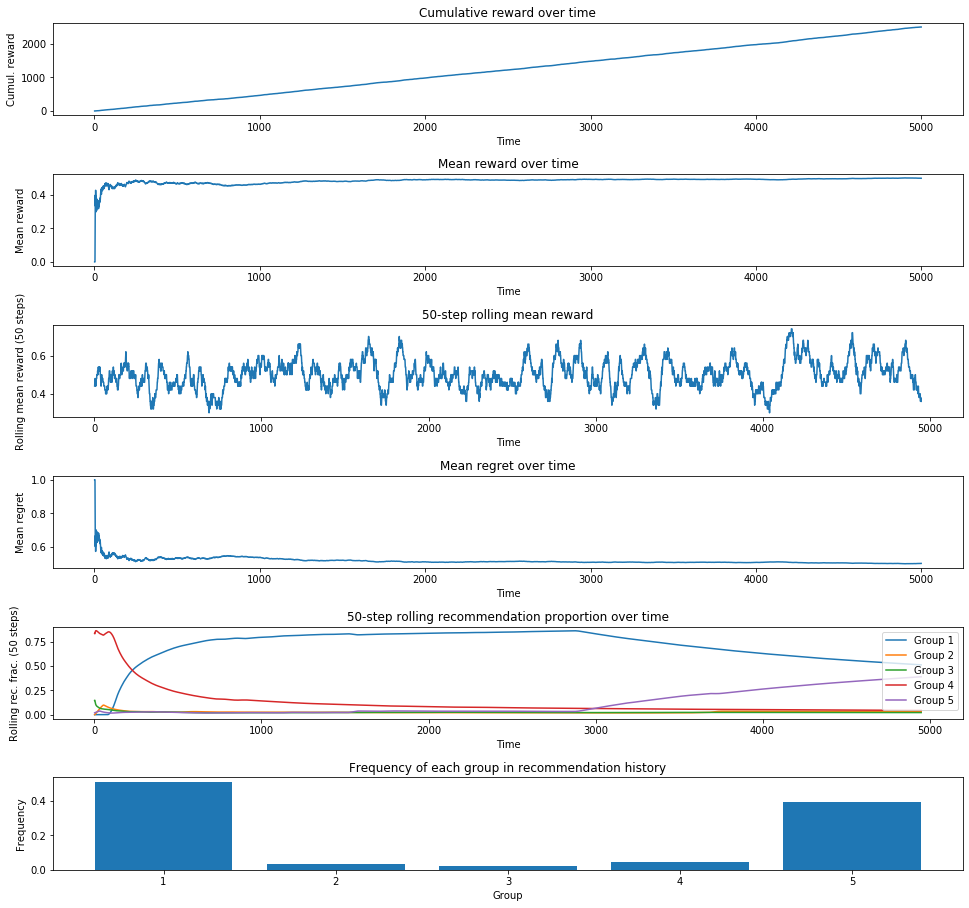

In [8]:
score(history_eps, n_arms = arms)

### UCB

Group frequencies                 : [0.144  0.119  0.119  0.4154 0.2026]
Max gap between group frequencies : 0.2964


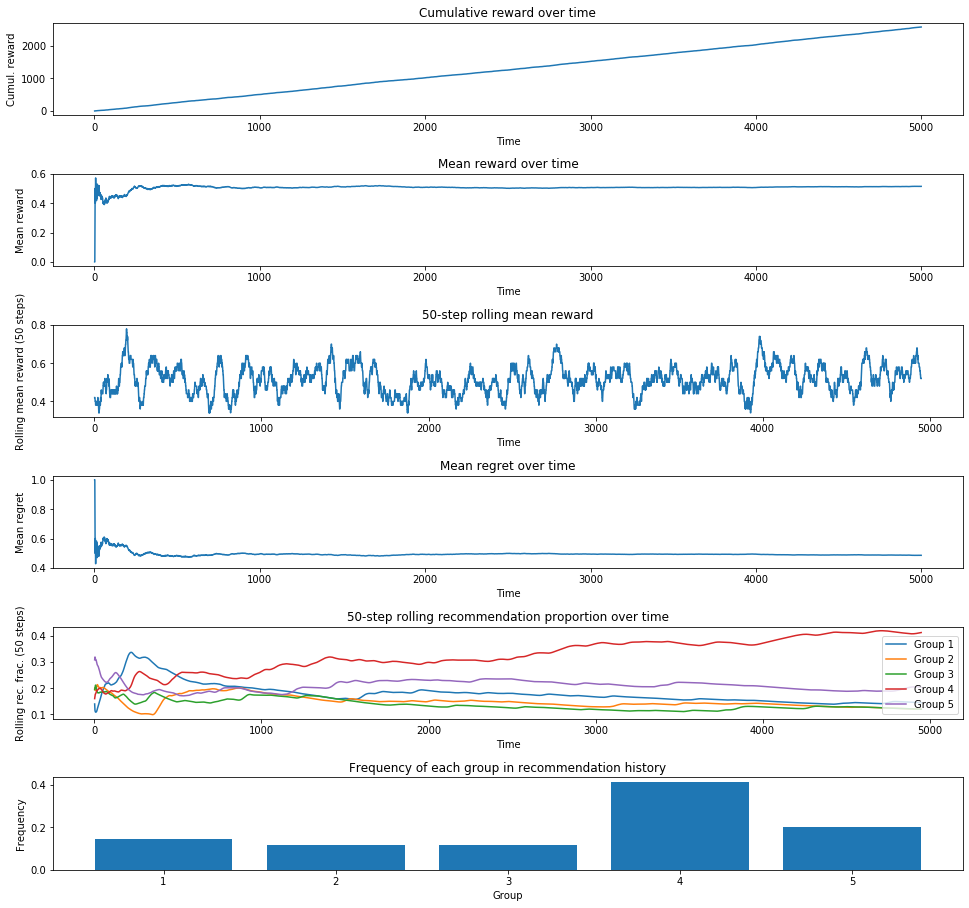

In [9]:
score(history_ucb, n_arms = arms)

### Thompson Sampling

Group frequencies                 : [0.3054 0.0738 0.0144 0.3942 0.2122]
Max gap between group frequencies : 0.37979999999999997


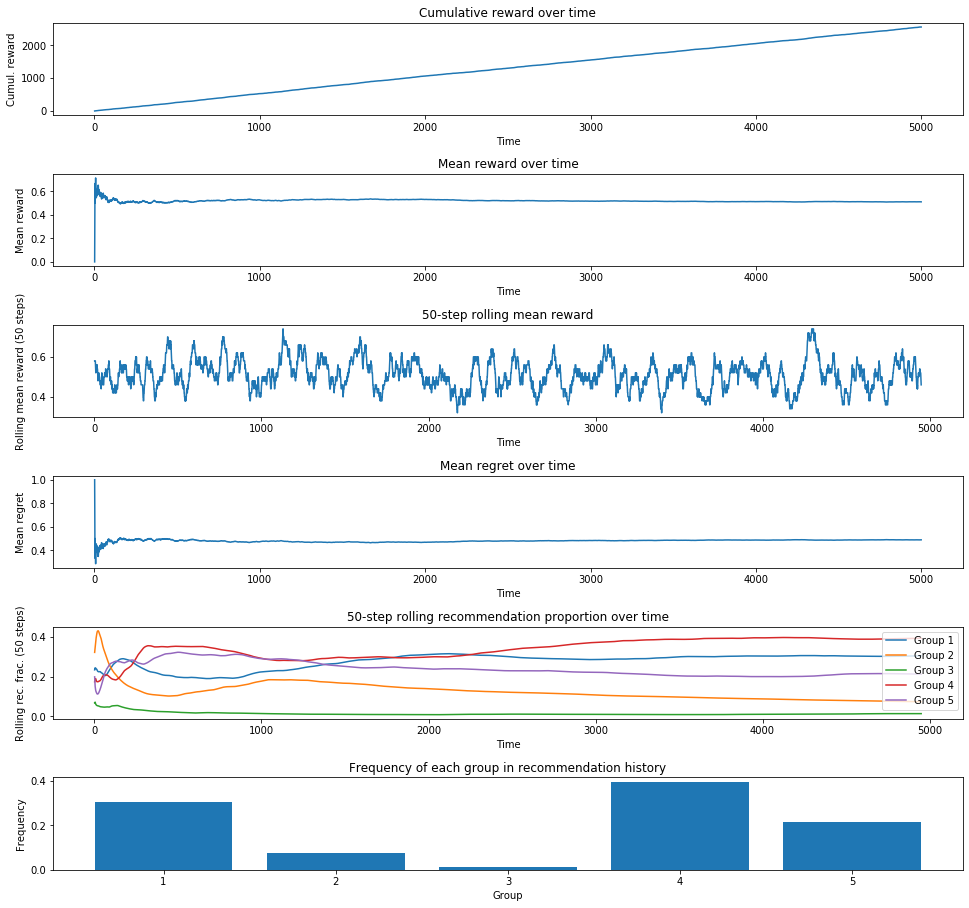

In [10]:
score(history_th, n_arms = arms)

### Exp3

Group frequencies                 : [0.3656 0.2332 0.0742 0.1754 0.1516]
Max gap between group frequencies : 0.2914


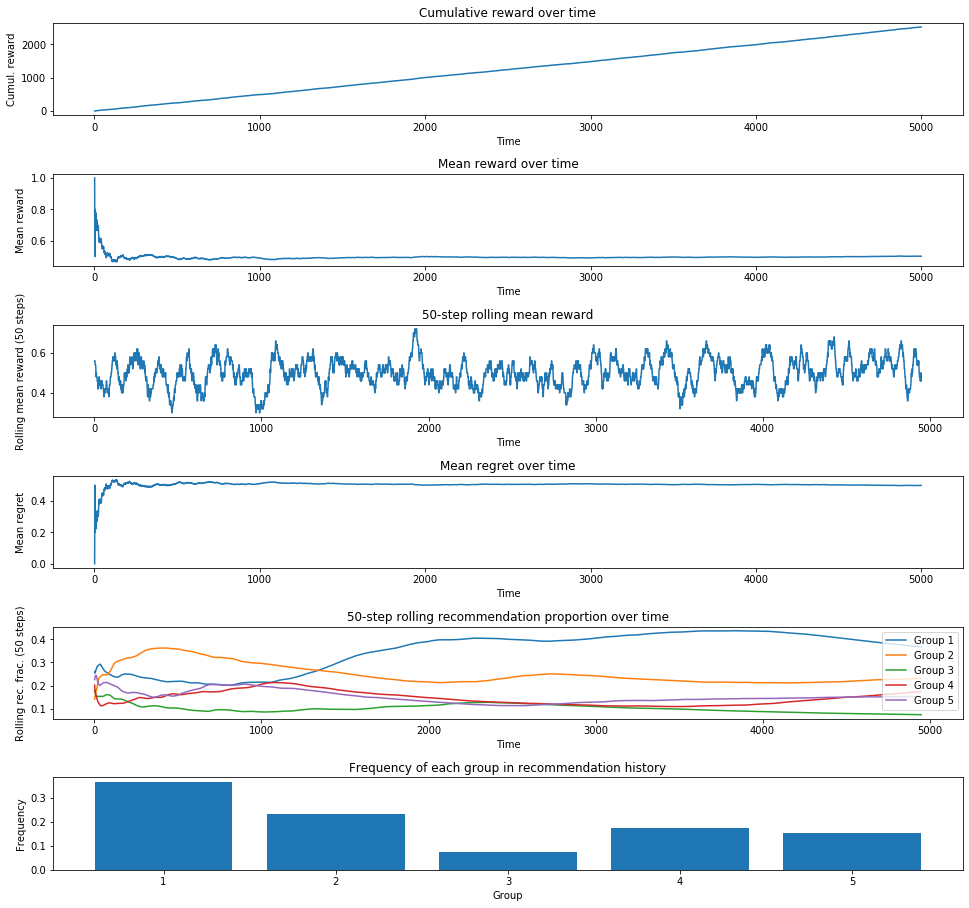

In [11]:
score(history_exp3, n_arms = arms)

## Second User: Likes group #5, nothing else ($p_5 = 1$, $p_i = 0 \ \forall \ i < 5$)

### Generate user data

In [12]:
user2 = new_user(2, n = m, n_arms = arms, preferences = [1, 0, 0, 0, 0], print_stats = True)

--- Stats for user 2 : --- 

Group representation: 
 [[1.     0.1989]
 [2.     0.1926]
 [3.     0.204 ]
 [4.     0.2027]
 [5.     0.2018]]

 --------------------- 

Proportion of liked items inside each group: 
 [[1. 1.]
 [2. 0.]
 [3. 0.]
 [4. 0.]
 [5. 0.]]

 --------------------- 

Proportion of all likes allocated to each group: 
 [[1. 1.]
 [2. 0.]
 [3. 0.]
 [4. 0.]
 [5. 0.]]

 --------------------- 

User data: 
 [[2 1 1]
 [2 3 0]
 [2 1 1]
 [2 1 1]
 [2 5 0]
 [2 4 0]
 [2 2 0]
 [2 1 1]
 [2 3 0]
 [2 4 0]
 [2 2 0]
 [2 2 0]
 [2 2 0]
 [2 5 0]
 [2 3 0]
 [2 5 0]
 [2 1 1]
 [2 2 0]
 [2 3 0]
 [2 2 0]
 [2 3 0]
 [2 5 0]
 [2 4 0]
 [2 3 0]
 [2 4 0]
 [2 3 0]
 [2 4 0]
 [2 3 0]
 [2 5 0]
 [2 5 0]
 [2 2 0]
 [2 1 1]
 [2 5 0]
 [2 3 0]
 [2 3 0]
 [2 3 0]
 [2 4 0]
 [2 3 0]
 [2 4 0]
 [2 2 0]
 [2 2 0]
 [2 1 1]
 [2 4 0]
 [2 5 0]
 [2 4 0]
 [2 4 0]
 [2 2 0]
 [2 4 0]
 [2 5 0]
 [2 4 0]
 [2 1 1]
 [2 3 0]
 [2 5 0]
 [2 2 0]
 [2 2 0]
 [2 1 1]
 [2 4 0]
 [2 5 0]
 [2 1 1]
 [2 4 0]
 [2 4 0]
 [2 2 0]
 [2 5 0]
 [2 5 0]
 [2 

### Agents initialization and training

In [13]:
# Initialize agents
eps2   = EpsilonGreedy(epsilon = param_epsilon)
ucb2   = UCB(bonus_multiplier = param_multiplier)
th2    = Thompson()
exp3_2 = Exp3(gamma = param_gamma)

# Train agents
history_rdm2   = train(user2,    rdm, steps = rounds)
history_eps2   = train(user2,   eps2, steps = rounds)
history_ucb2   = train(user2,   ucb2, steps = rounds)
history_th2    = train(user2,    th2, steps = rounds)
history_exp3_2 = train(user2, exp3_2, steps = rounds)

----- Successfully trained Random Agent -----
----- Successfully trained Epsilon Greedy Agent -----
----- Successfully trained UCB Agent -----
----- Successfully trained Thompson Sampling Agent -----
----- Successfully trained Exp3 Agent -----


### Random Agent

Group frequencies                 : [0.191  0.203  0.2036 0.2006 0.2018]
Max gap between group frequencies : 0.0126


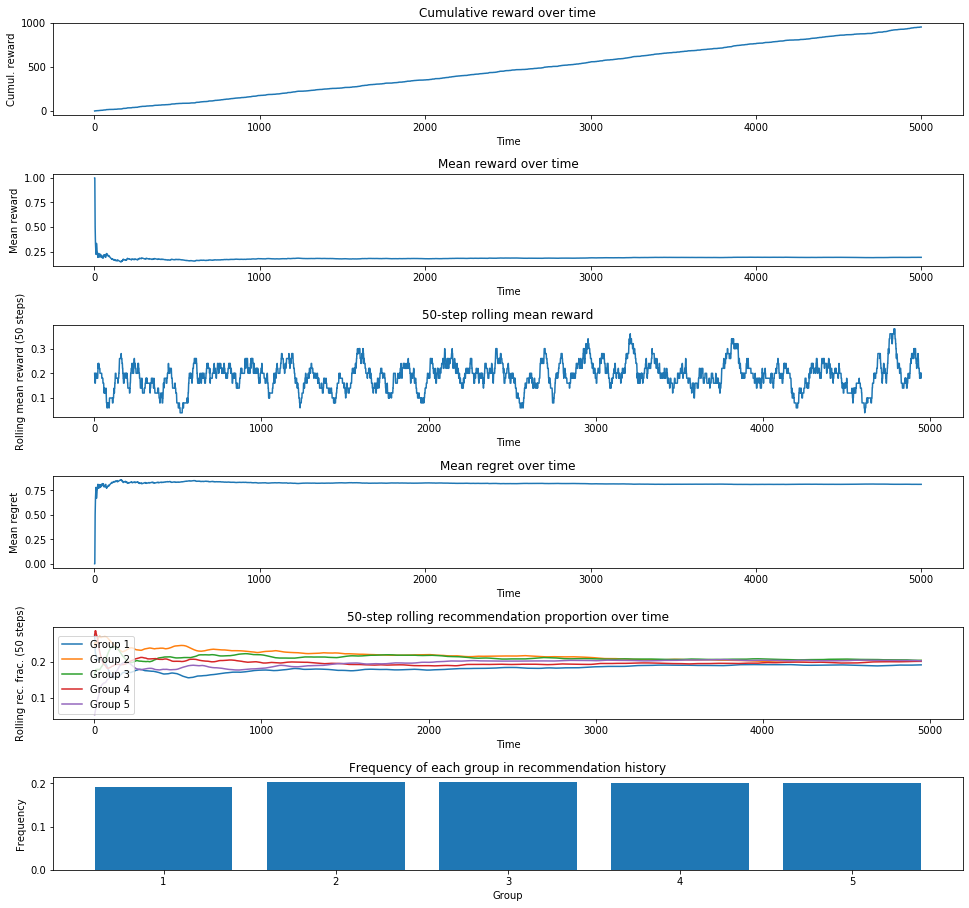

In [14]:
score(history_rdm2, n_arms = arms)

### $\epsilon$-Greedy

Group frequencies                 : [0.9142 0.0226 0.0214 0.0212 0.0206]
Max gap between group frequencies : 0.8936000000000001


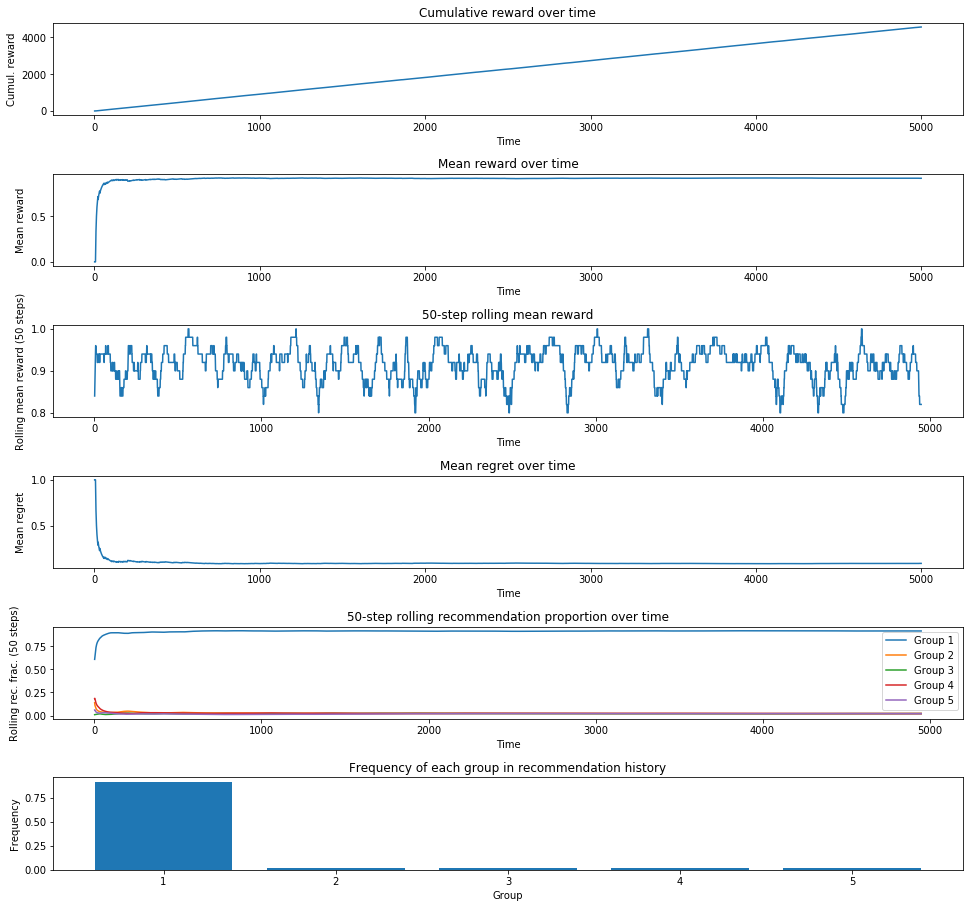

In [15]:
score(history_eps2, n_arms = arms)

### UCB

Group frequencies                 : [0.988 0.003 0.003 0.003 0.003]
Max gap between group frequencies : 0.985


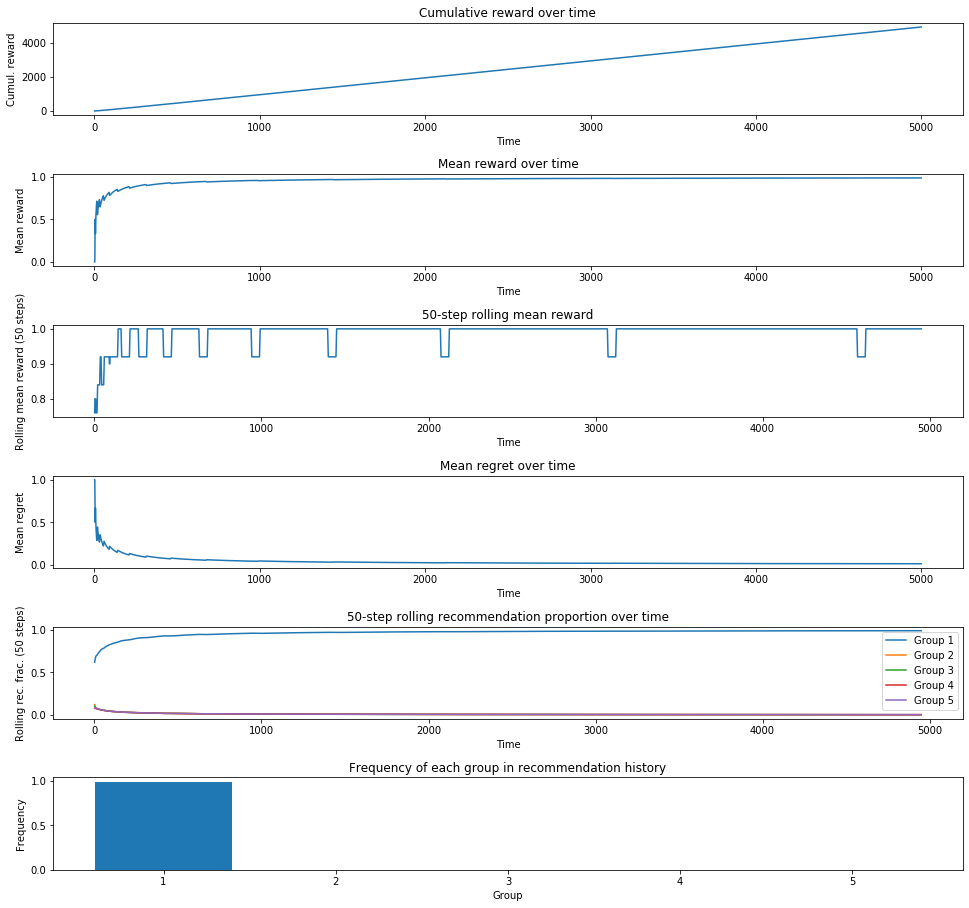

In [16]:
score(history_ucb2, n_arms = arms)

### Thompson Sampling

Group frequencies                 : [9.984e-01 4.000e-04 4.000e-04 4.000e-04 4.000e-04]
Max gap between group frequencies : 0.998


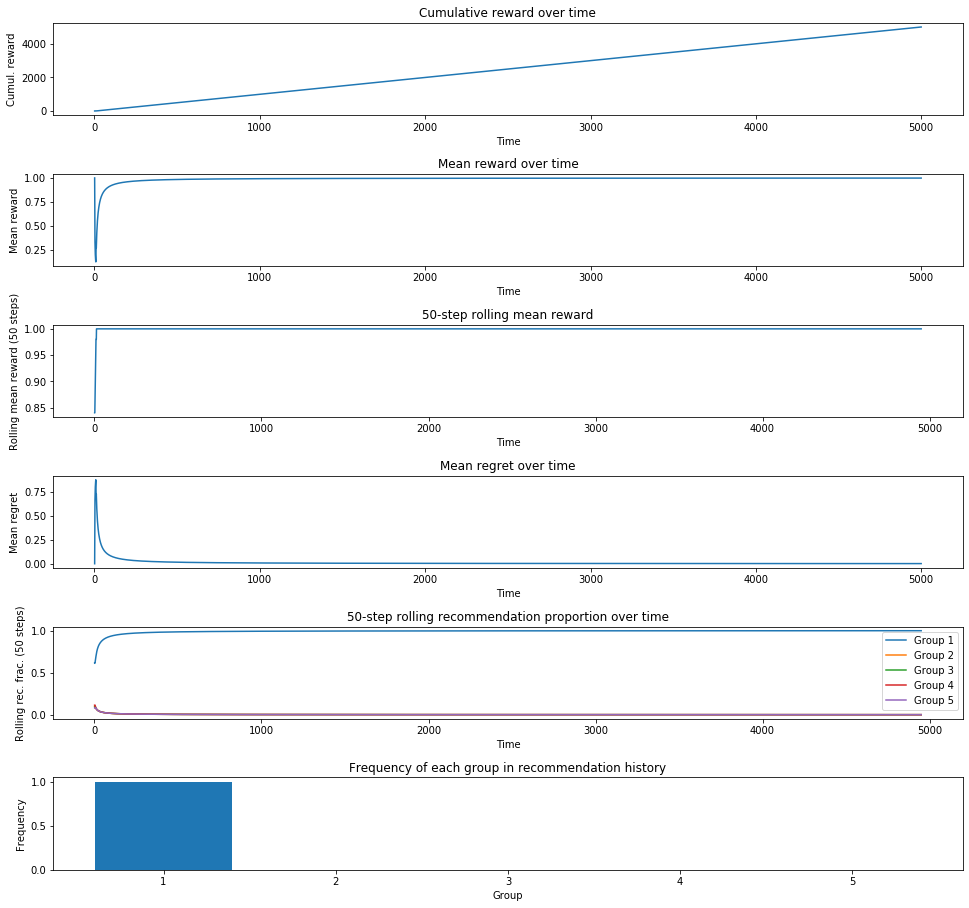

In [17]:
score(history_th2, n_arms = arms)

### Exp3

Group frequencies                 : [0.9122 0.02   0.0236 0.021  0.0232]
Max gap between group frequencies : 0.8922


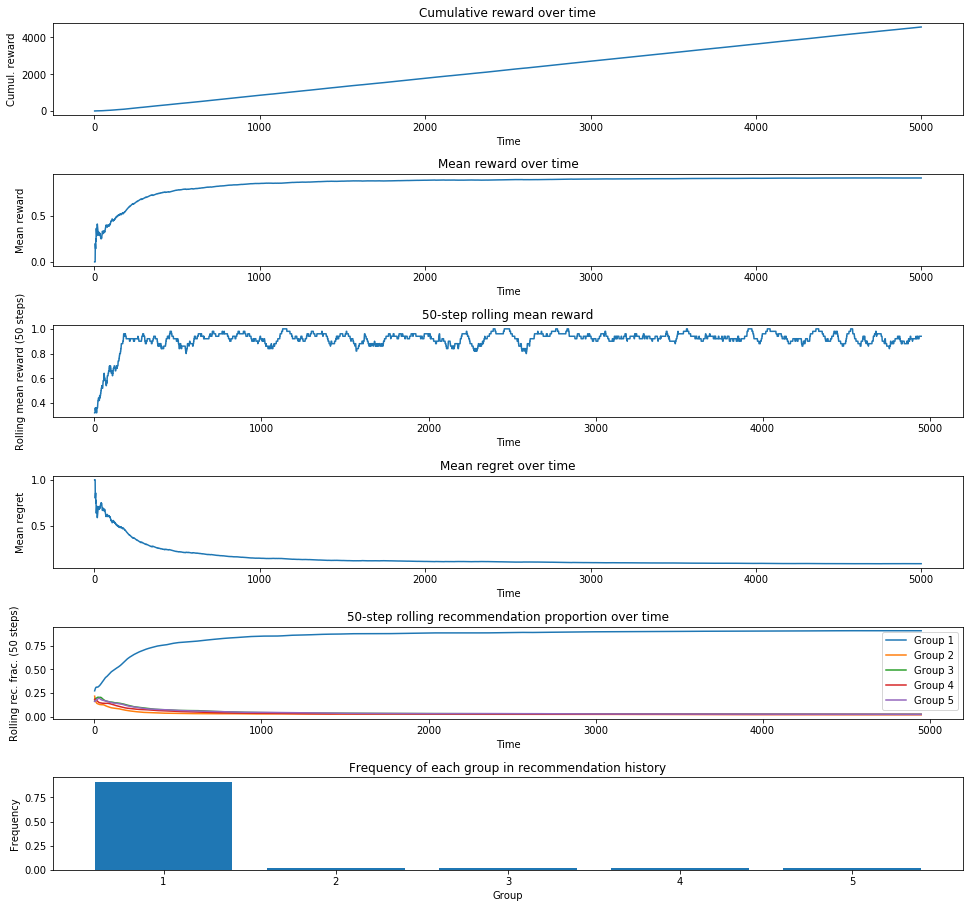

In [18]:
score(history_exp3_2, n_arms = arms)

## Third User: prefers groups #1 and #2 ($p_1 = p_2 = 0.9$, $p_i = 0.5 \ \forall \ i > 2$)

### Generate user data

In [19]:
user3 = new_user(3, n = m, n_arms = arms, preferences = [0.9, 0.9, 0.5, 0.5, 0.5], print_stats = True)

--- Stats for user 3 : --- 

Group representation: 
 [[1.     0.1951]
 [2.     0.2005]
 [3.     0.205 ]
 [4.     0.1974]
 [5.     0.202 ]]

 --------------------- 

Proportion of liked items inside each group: 
 [[1.         0.90158893]
 [2.         0.90473815]
 [3.         0.49707317]
 [4.         0.49138804]
 [5.         0.51584158]]

 --------------------- 

Proportion of all likes allocated to each group: 
 [[1.         0.26635373]
 [2.         0.27468201]
 [3.         0.15430042]
 [4.         0.14688068]
 [5.         0.15778316]]

 --------------------- 

User data: 
 [[3 3 1]
 [3 5 1]
 [3 1 1]
 [3 4 1]
 [3 4 1]
 [3 4 1]
 [3 5 0]
 [3 3 0]
 [3 2 1]
 [3 2 1]
 [3 4 1]
 [3 5 0]
 [3 3 0]
 [3 5 1]
 [3 5 0]
 [3 3 1]
 [3 4 0]
 [3 3 1]
 [3 2 1]
 [3 3 1]
 [3 1 1]
 [3 3 1]
 [3 5 1]
 [3 4 1]
 [3 5 0]
 [3 1 1]
 [3 2 1]
 [3 5 0]
 [3 4 0]
 [3 1 1]
 [3 4 1]
 [3 5 0]
 [3 4 1]
 [3 2 1]
 [3 3 1]
 [3 1 1]
 [3 2 1]
 [3 2 1]
 [3 4 1]
 [3 1 1]
 [3 2 1]
 [3 3 1]
 [3 5 1]
 [3 1 1]
 [3 3 1]
 [3 3 0]
 [3 4 

### Agents initialization and training

In [20]:
# Initialize agents
eps3   = EpsilonGreedy(epsilon = param_epsilon)
ucb3   = UCB(bonus_multiplier = param_multiplier)
th3    = Thompson()
exp3_3 = Exp3(gamma = param_gamma)

# Train agents
history_rdm3   = train(user3,    rdm, steps = rounds)
history_eps3   = train(user3,   eps3, steps = rounds)
history_ucb3   = train(user3,   ucb3, steps = rounds)
history_th3    = train(user3,    th3, steps = rounds)
history_exp3_3 = train(user3, exp3_3, steps = rounds)

----- Successfully trained Random Agent -----
----- Successfully trained Epsilon Greedy Agent -----
----- Successfully trained UCB Agent -----
----- Successfully trained Thompson Sampling Agent -----
----- Successfully trained Exp3 Agent -----


### Random Agent

Group frequencies                 : [0.2018 0.2068 0.1958 0.1964 0.1992]
Max gap between group frequencies : 0.01100000000000001


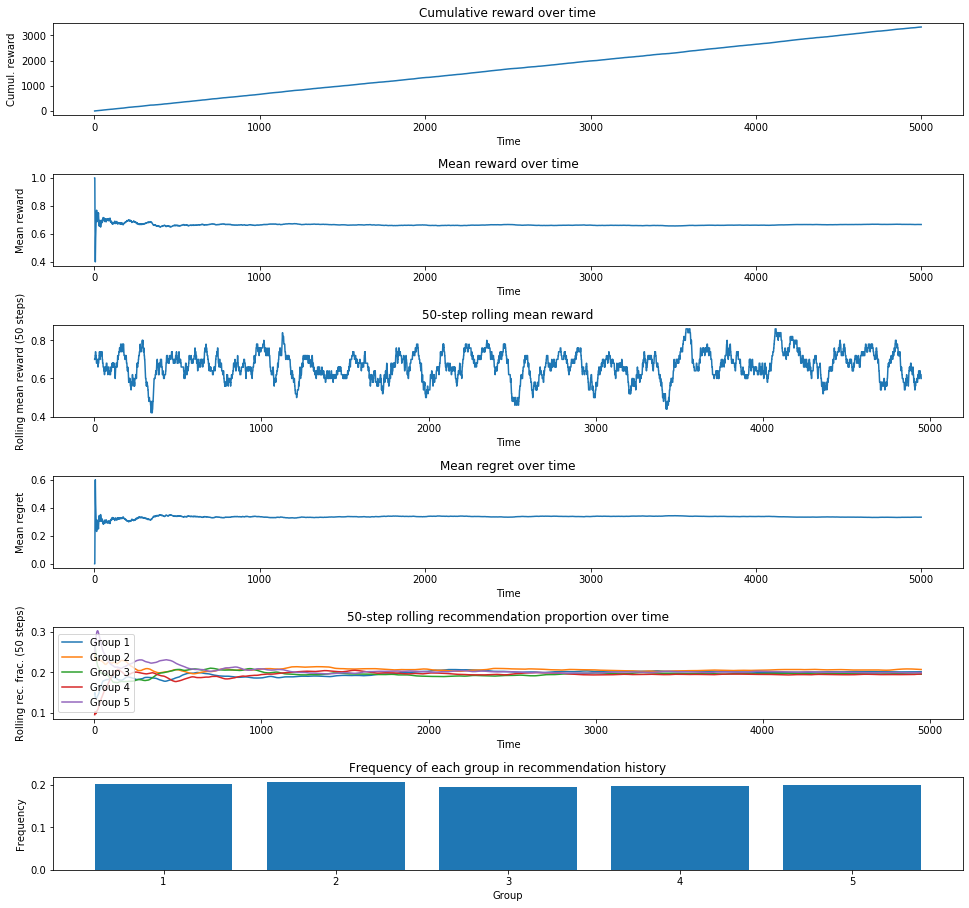

In [21]:
score(history_rdm3, n_arms = arms)

### $\epsilon$-Greedy

Group frequencies                 : [0.4146 0.5176 0.0246 0.02   0.0232]
Max gap between group frequencies : 0.49759999999999993


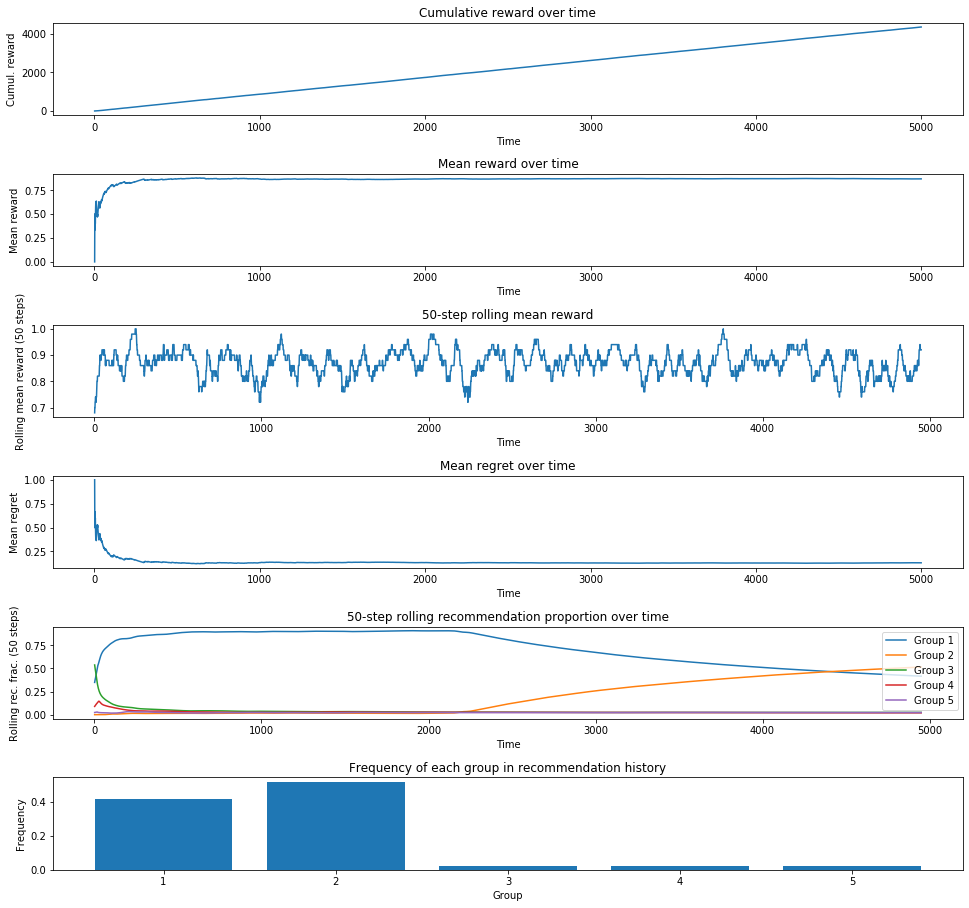

In [22]:
score(history_eps3, n_arms = arms)

### UCB

Group frequencies                 : [0.4926 0.4692 0.0126 0.009  0.0166]
Max gap between group frequencies : 0.4836


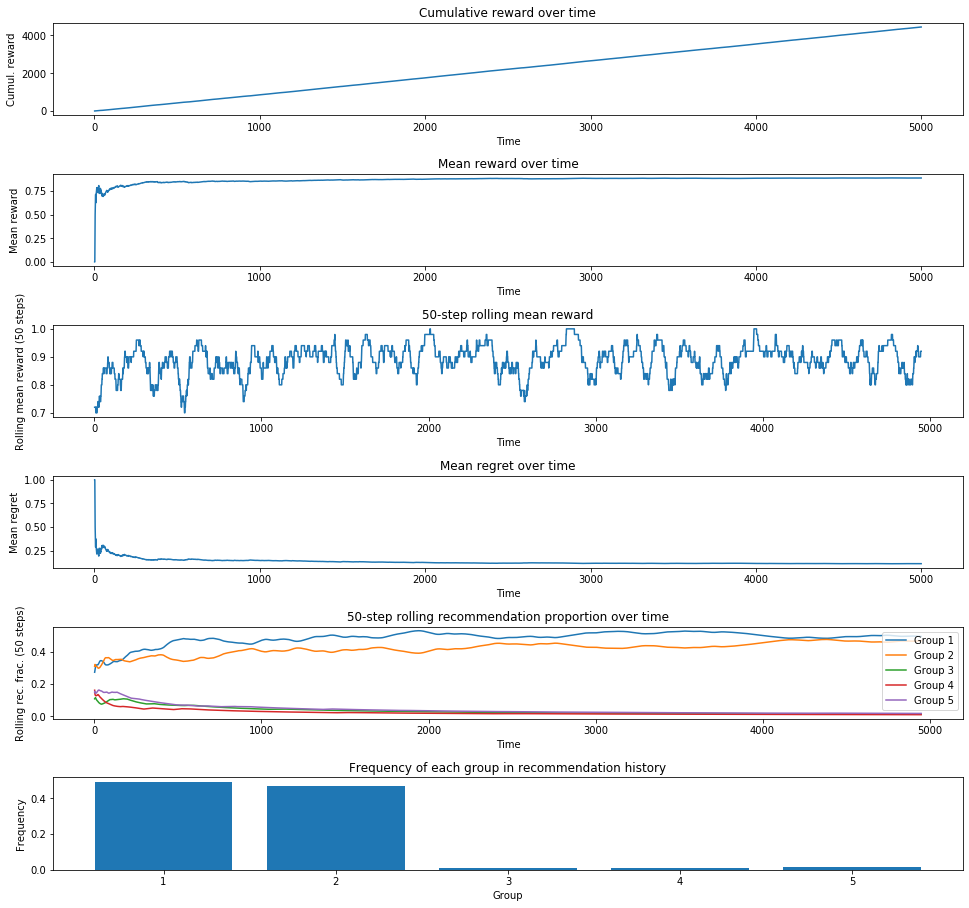

In [23]:
score(history_ucb3, n_arms = arms)

### Thompson Sampling

Group frequencies                 : [0.1228 0.8724 0.0022 0.0016 0.001 ]
Max gap between group frequencies : 0.8714


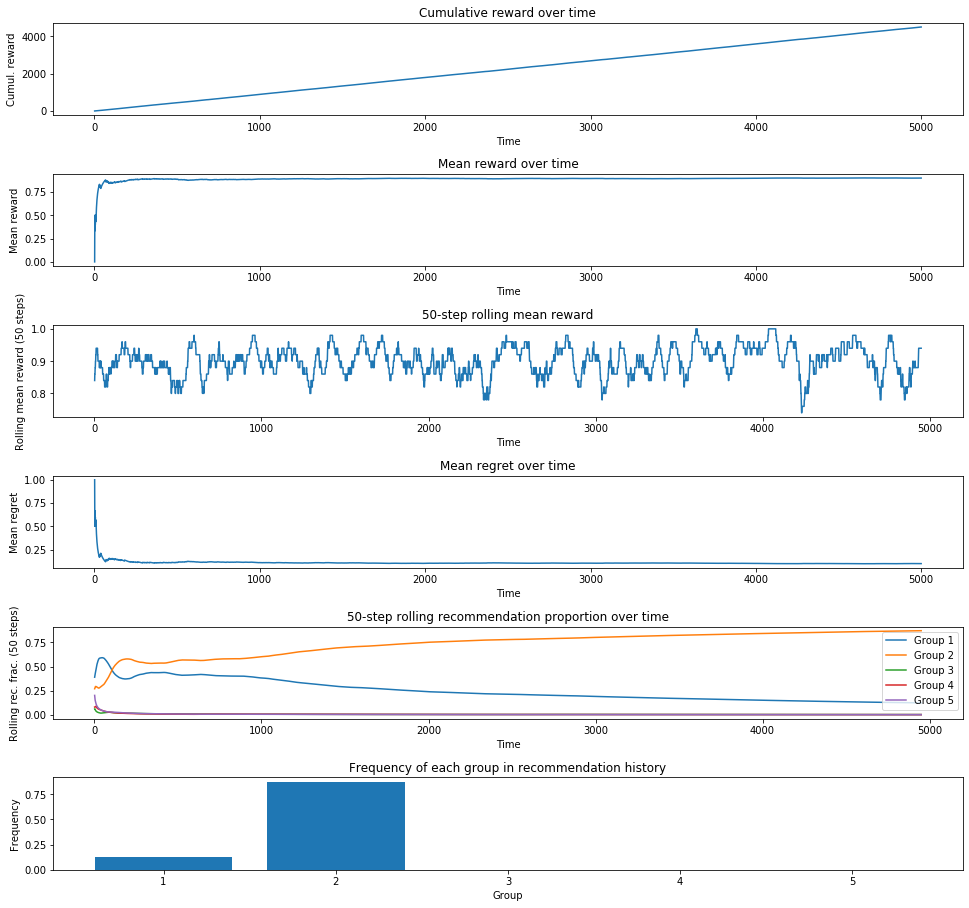

In [24]:
score(history_th3, n_arms = arms)

### Exp3

Group frequencies                 : [0.7072 0.2126 0.0254 0.0302 0.0246]
Max gap between group frequencies : 0.6826000000000001


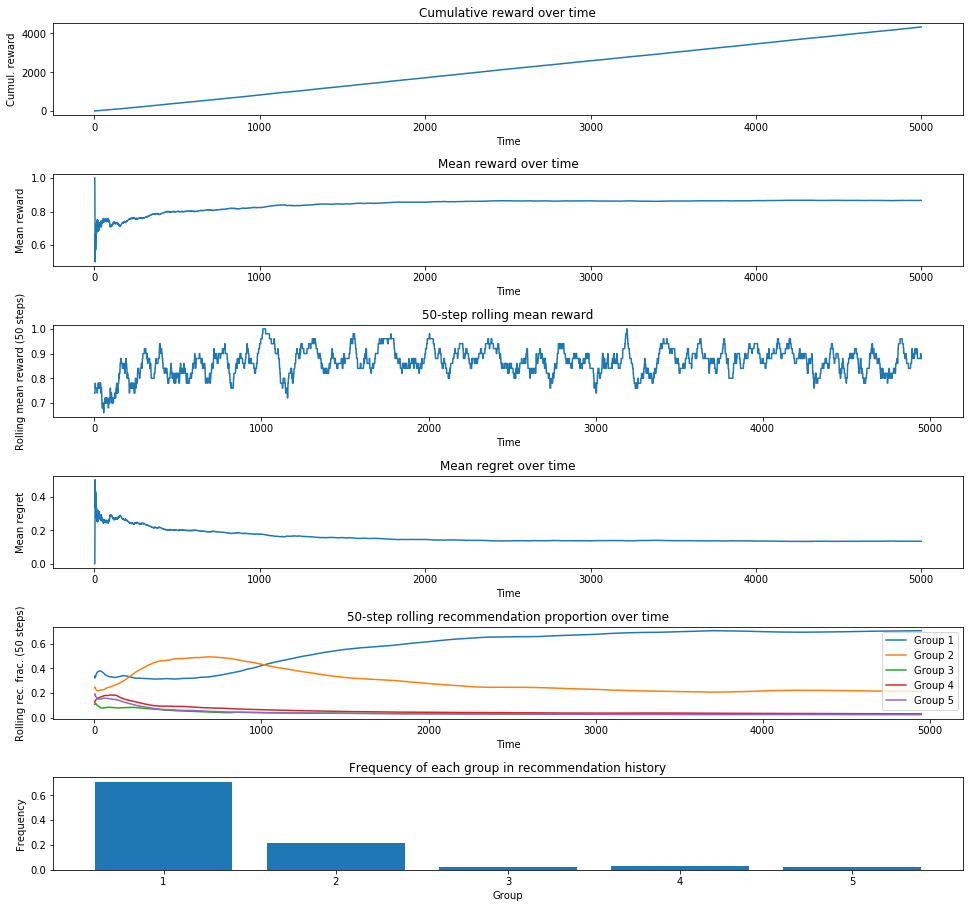

In [25]:
score(history_exp3_3, n_arms = arms, rolling = 50)

# B. The Depolarized Setting

## First User: Random Preferences ($p_i = 0.5 \ \forall \ i$)

### Agents initialization and training

In [26]:
# Initialize agents
eps  = EpsilonGreedy(epsilon = param_epsilon, depolarize = True, upper = 0.6)
ucb  = UCB(bonus_multiplier = param_multiplier, depolarize = True, upper = 0.6)
th   = Thompson(depolarize = True, upper = 0.6)
exp3 = Exp3(gamma = param_gamma, depolarize = True, upper = 0.6)

# Train agents
history_eps  = train(user,  eps, steps = rounds)
history_ucb  = train(user,  ucb, steps = rounds)
history_th   = train(user,   th, steps = rounds)
history_exp3 = train(user, exp3, steps = rounds)

----- Successfully trained Epsilon Greedy Agent -----
----- Successfully trained UCB Agent -----
----- Successfully trained Thompson Sampling Agent -----
----- Successfully trained Exp3 Agent -----


### $\epsilon$-Greedy

Group frequencies                 : [0.092  0.0888 0.0922 0.5998 0.1272]
Max gap between group frequencies : 0.511


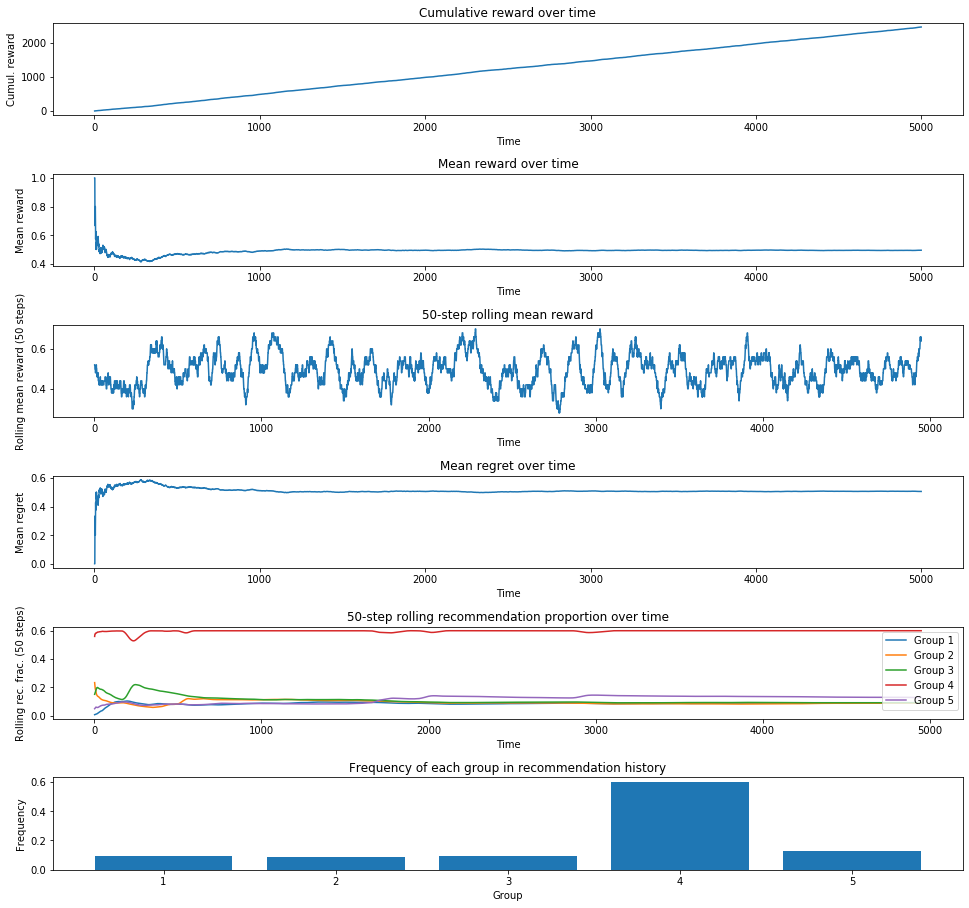

In [27]:
score(history_eps, n_arms = arms)

### UCB

Group frequencies                 : [0.2282 0.127  0.1152 0.3726 0.157 ]
Max gap between group frequencies : 0.25739999999999996


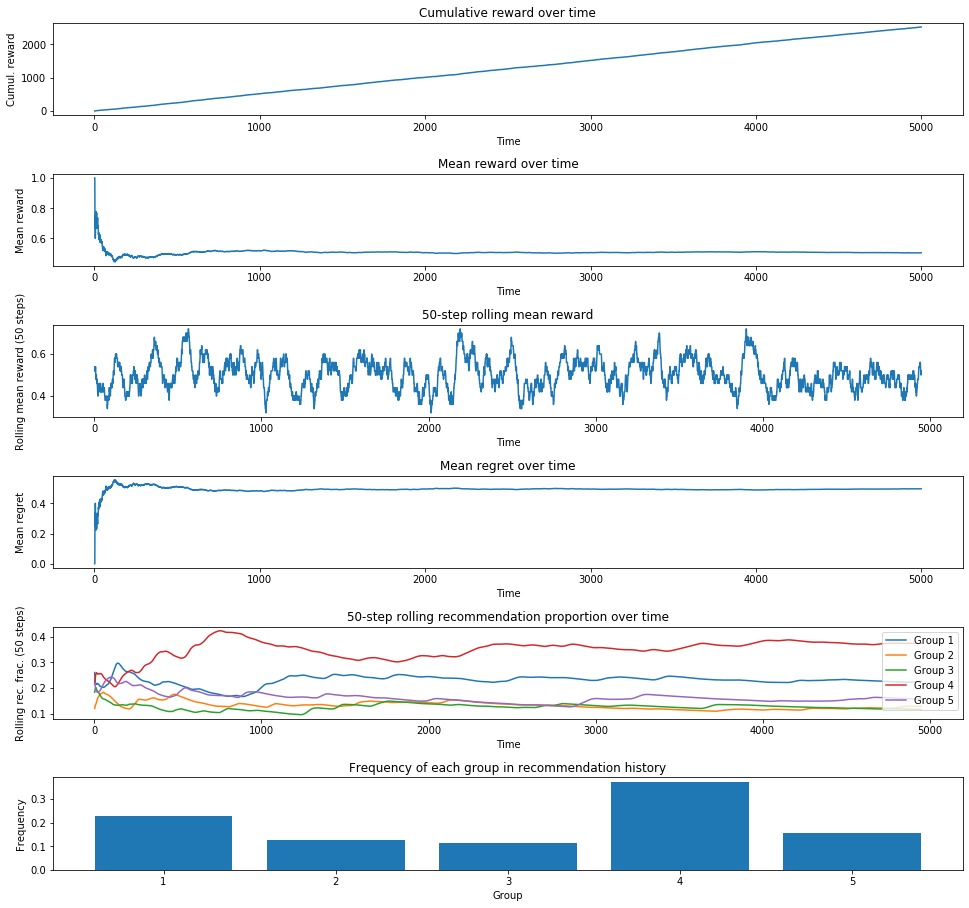

In [28]:
score(history_ucb, n_arms = arms)

### Thompson Sampling

Group frequencies                 : [0.0342 0.1616 0.084  0.5856 0.1346]
Max gap between group frequencies : 0.5514


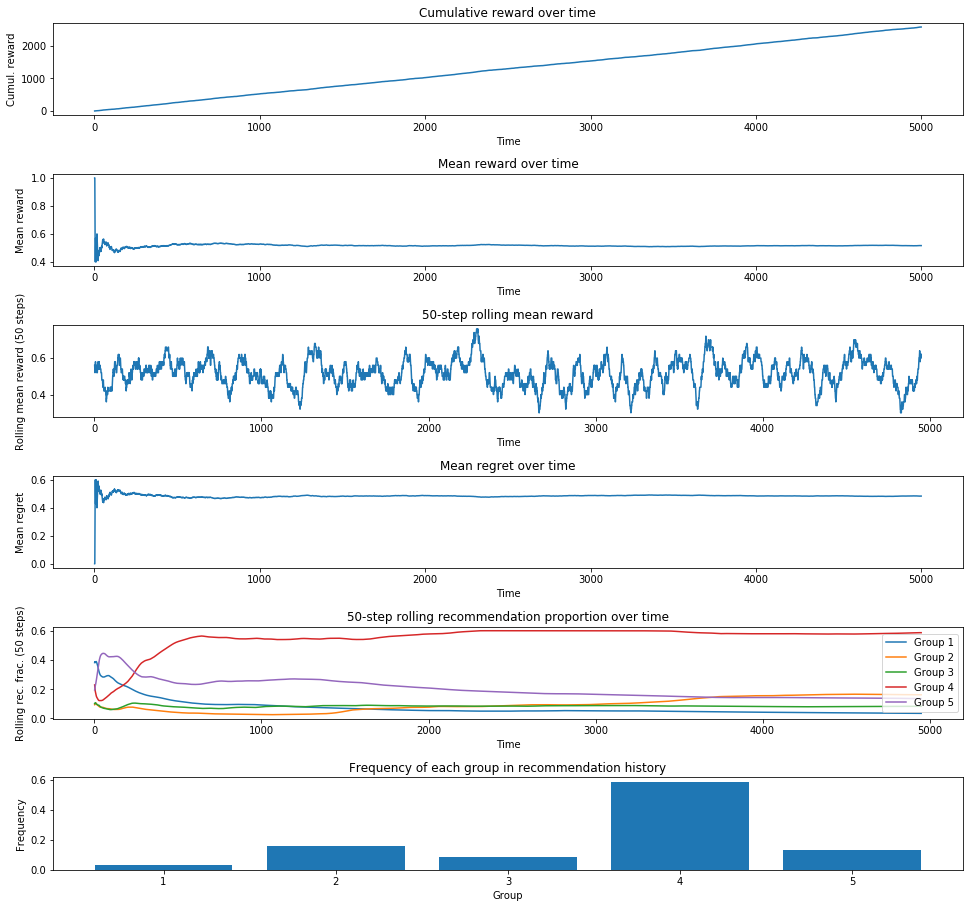

In [29]:
score(history_th, n_arms = arms)

### Exp3

Group frequencies                 : [0.2196 0.2564 0.0434 0.4406 0.04  ]
Max gap between group frequencies : 0.4006


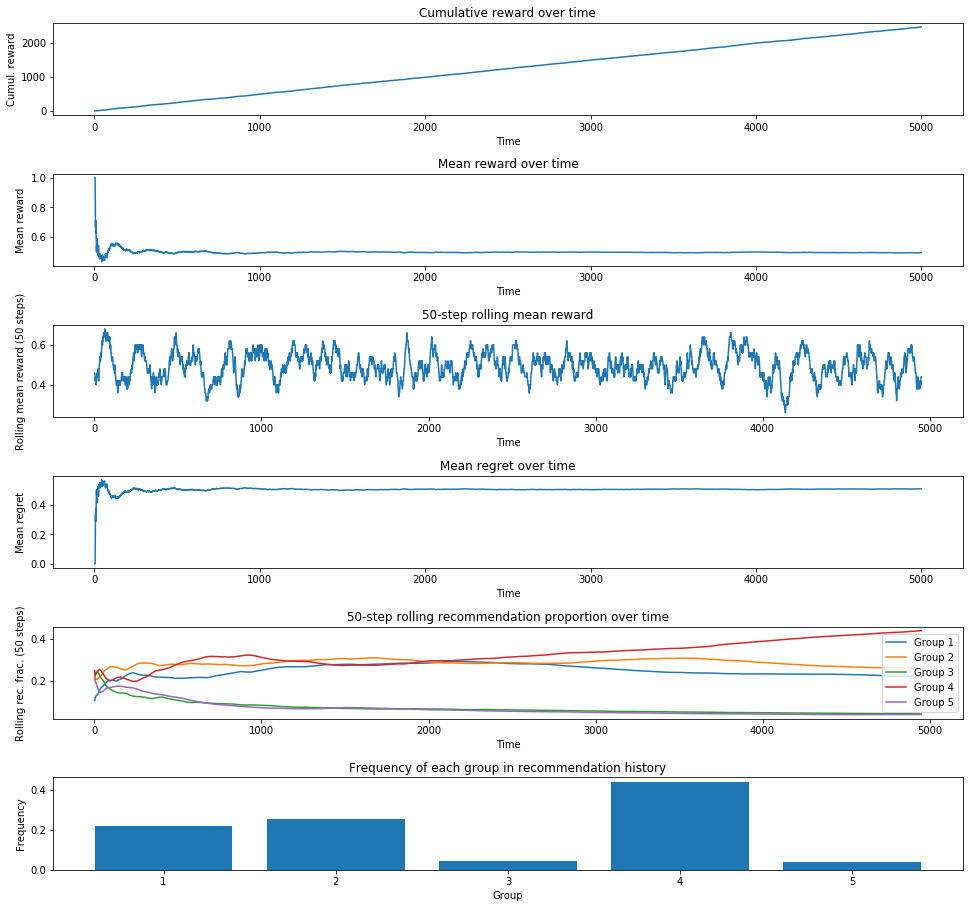

In [30]:
score(history_exp3, n_arms = arms)

## Second User: Likes group #5, nothing else ($p_5 = 1$, $p_i = 0 \ \forall \ i < 5$)

### Agents initialization and training

In [31]:
# Initialize agents
eps2   = EpsilonGreedy(epsilon = param_epsilon, depolarize = True, upper = 0.6)
ucb2   = UCB(bonus_multiplier = param_multiplier, depolarize = True, upper = 0.6)
th2    = Thompson(depolarize = True, upper = 0.6)
exp3_2 = Exp3(gamma = param_gamma, depolarize = True, upper = 0.6)

# Train agents
history_eps2   = train(user2,   eps2, steps = rounds)
history_ucb2   = train(user2,   ucb2, steps = rounds)
history_th2    = train(user2,    th2, steps = rounds)
history_exp3_2 = train(user2, exp3_2, steps = rounds)

----- Successfully trained Epsilon Greedy Agent -----
----- Successfully trained UCB Agent -----
----- Successfully trained Thompson Sampling Agent -----
----- Successfully trained Exp3 Agent -----


### $\epsilon$-Greedy

Group frequencies                 : [0.6    0.0988 0.0948 0.1032 0.1032]
Max gap between group frequencies : 0.5052


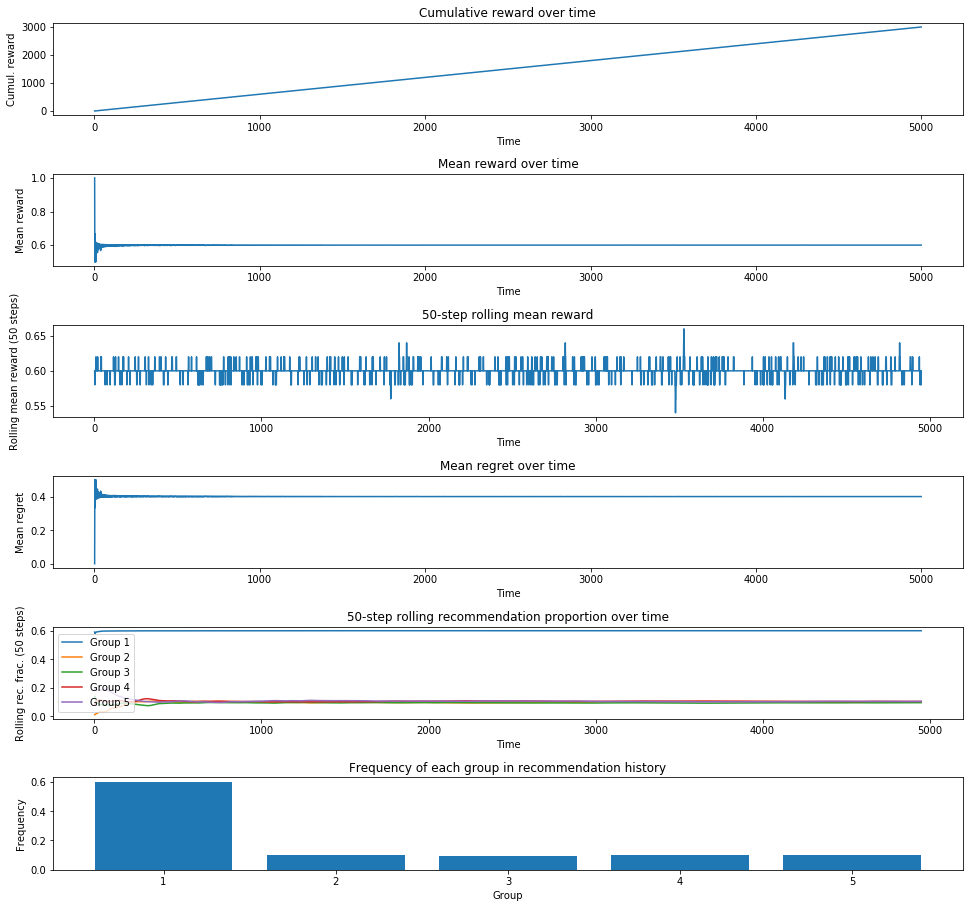

In [32]:
score(history_eps2, n_arms = arms)

### UCB

Group frequencies                 : [0.6    0.1044 0.1008 0.1002 0.0946]
Max gap between group frequencies : 0.5054


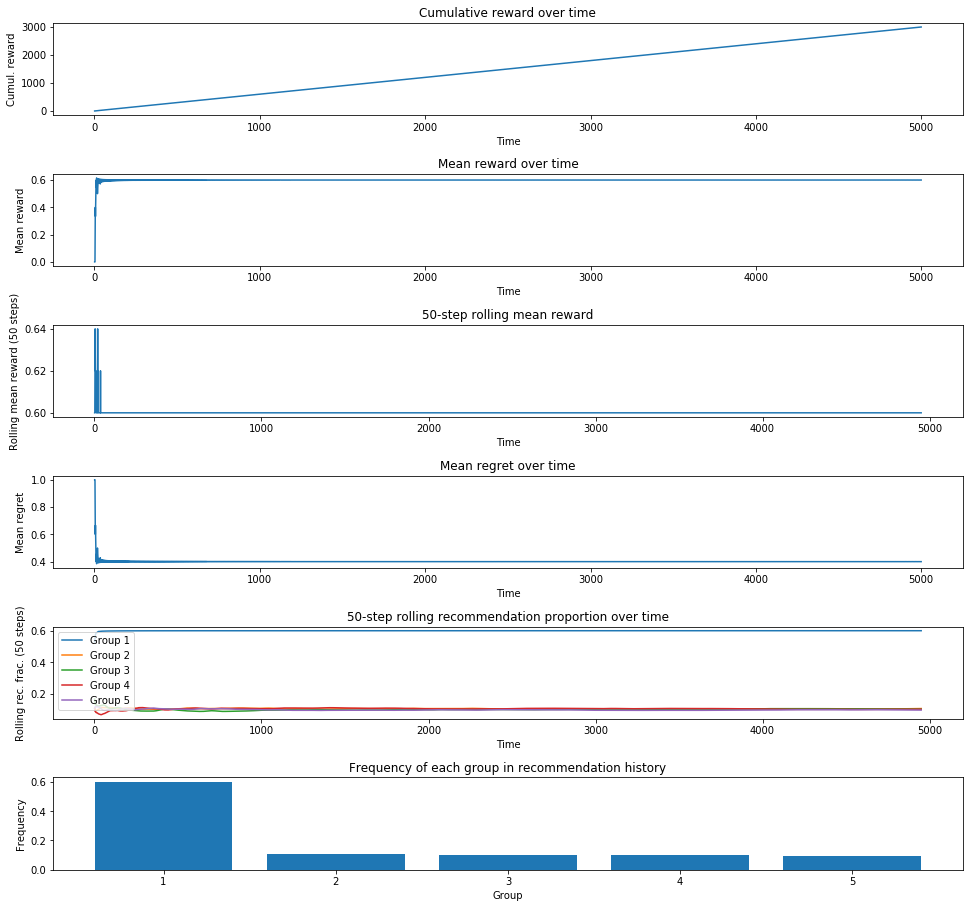

In [33]:
score(history_ucb2, n_arms = arms)

### Thompson Sampling

Group frequencies                 : [0.6    0.0994 0.1018 0.1028 0.096 ]
Max gap between group frequencies : 0.504


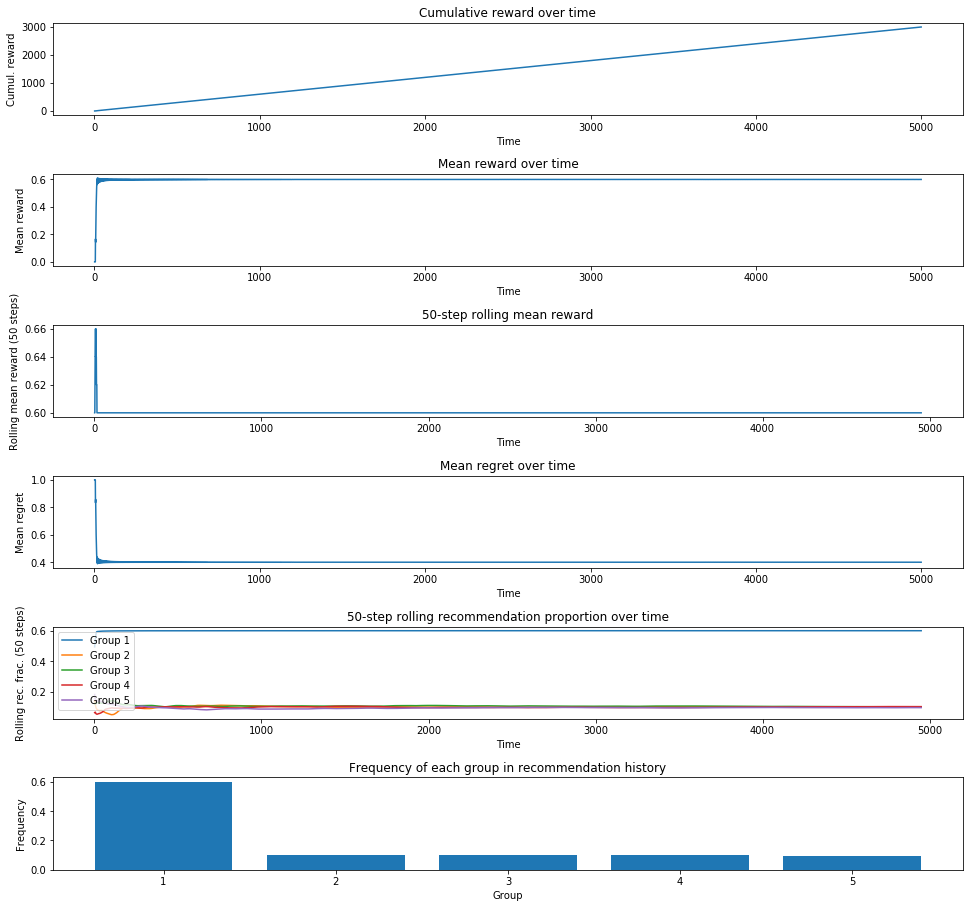

In [34]:
score(history_th2, n_arms = arms)

### Exp3

Group frequencies                 : [0.6    0.0974 0.1016 0.1014 0.0996]
Max gap between group frequencies : 0.5025999999999999


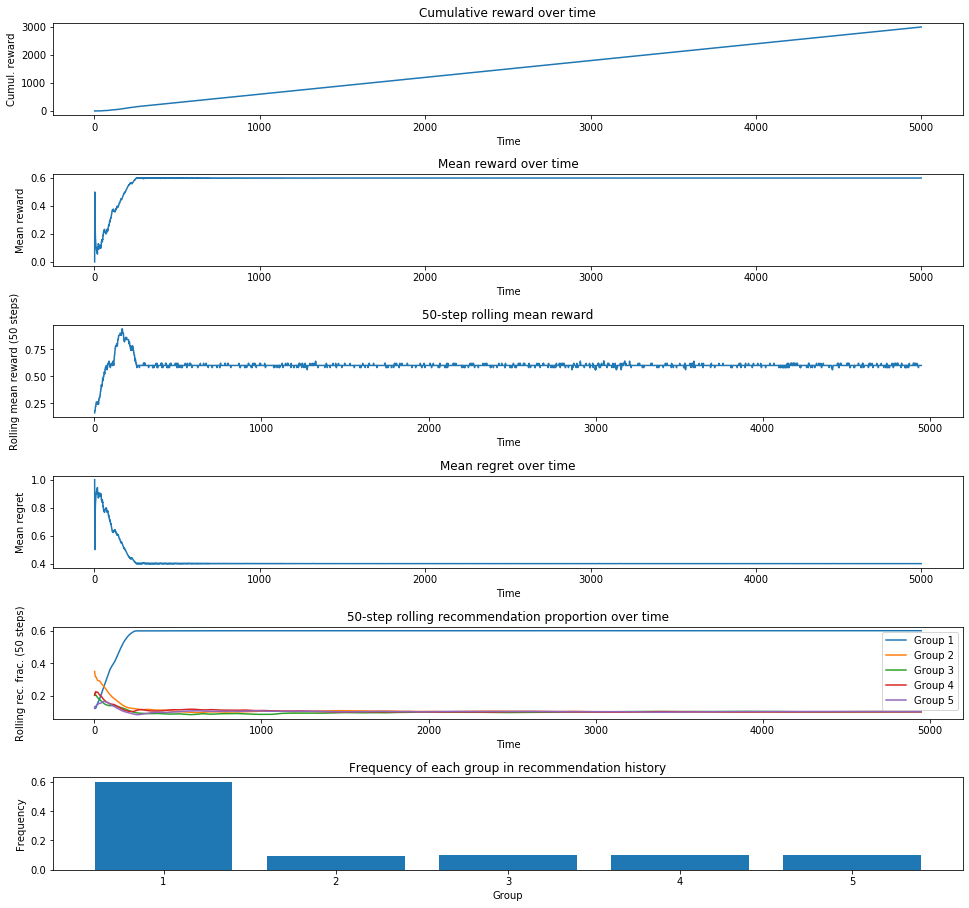

In [35]:
score(history_exp3_2, n_arms = arms)

## Third User: prefers groups #1 and #2 ($p_1 = p_2 = 0.9$, $p_i = 0.5 \ \forall \ i > 2$)

### Agents initialization and training

In [36]:
# Initialize agents
eps3 = EpsilonGreedy(epsilon = param_epsilon, depolarize = True, upper = 0.6)
ucb3 = UCB(bonus_multiplier = param_multiplier, depolarize = True, upper = 0.6)
th3 = Thompson(depolarize = True, upper = 0.6)
exp3_3 = Exp3(gamma = param_gamma, depolarize = True, upper = 0.6)

# Train agents
history_eps3   = train(user3,   eps3, steps = rounds)
history_ucb3   = train(user3,   ucb3, steps = rounds)
history_th3    = train(user3,    th3, steps = rounds)
history_exp3_3 = train(user3, exp3_3, steps = rounds)

----- Successfully trained Epsilon Greedy Agent -----
----- Successfully trained UCB Agent -----
----- Successfully trained Thompson Sampling Agent -----
----- Successfully trained Exp3 Agent -----


### $\epsilon$-Greedy

Group frequencies                 : [0.6    0.1186 0.0986 0.0898 0.093 ]
Max gap between group frequencies : 0.5102


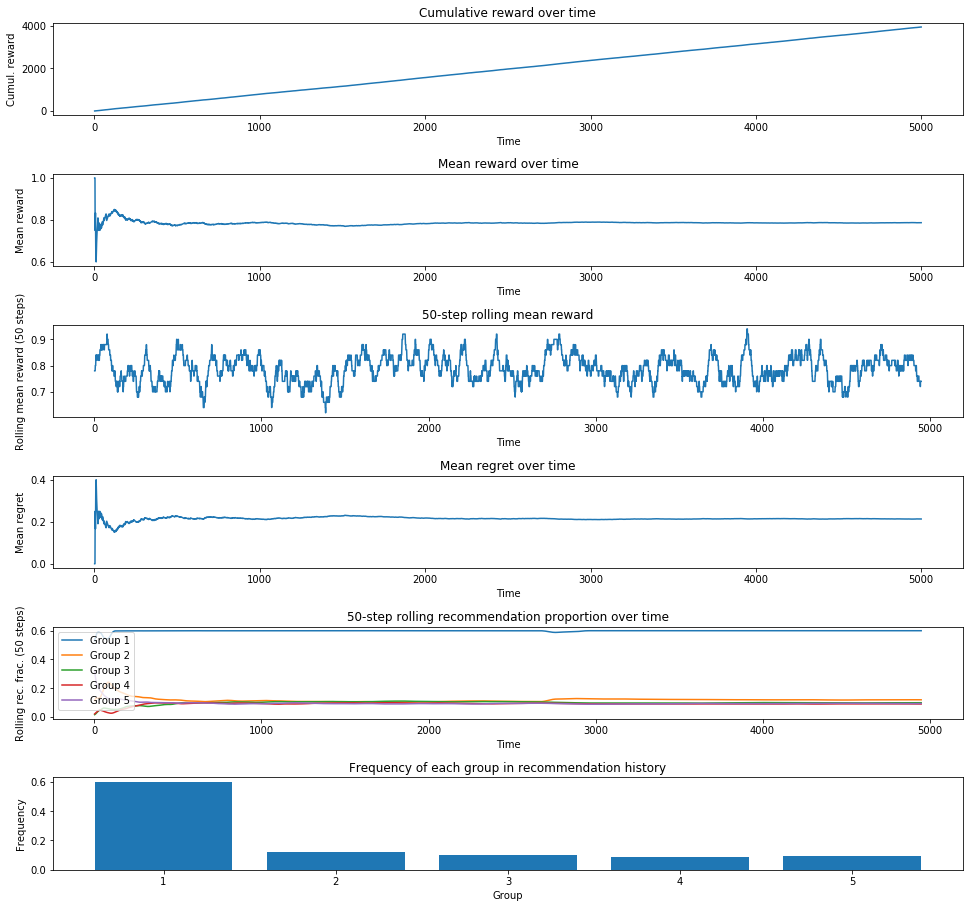

In [37]:
score(history_eps3, n_arms = arms)

### UCB

Group frequencies                 : [0.4858 0.4746 0.0106 0.0118 0.0172]
Max gap between group frequencies : 0.4752


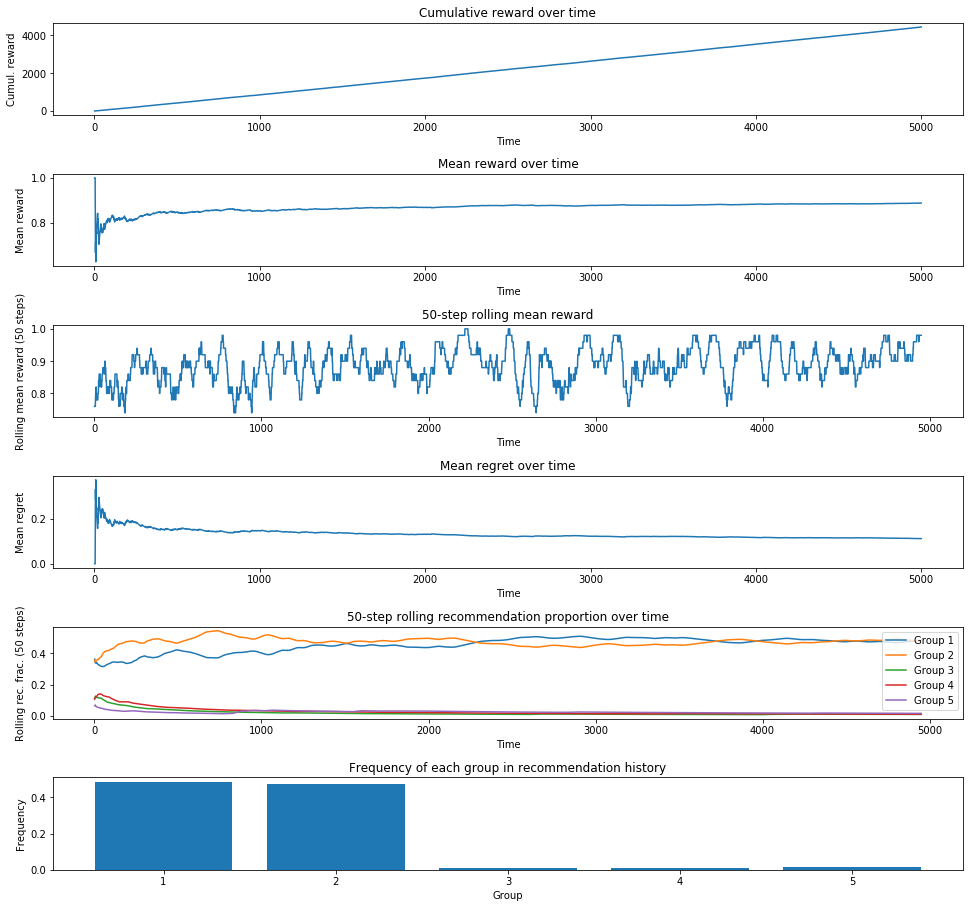

In [38]:
score(history_ucb3, n_arms = arms)

### Thompson Sampling

Group frequencies                 : [0.4432 0.541  0.0052 0.005  0.0056]
Max gap between group frequencies : 0.536


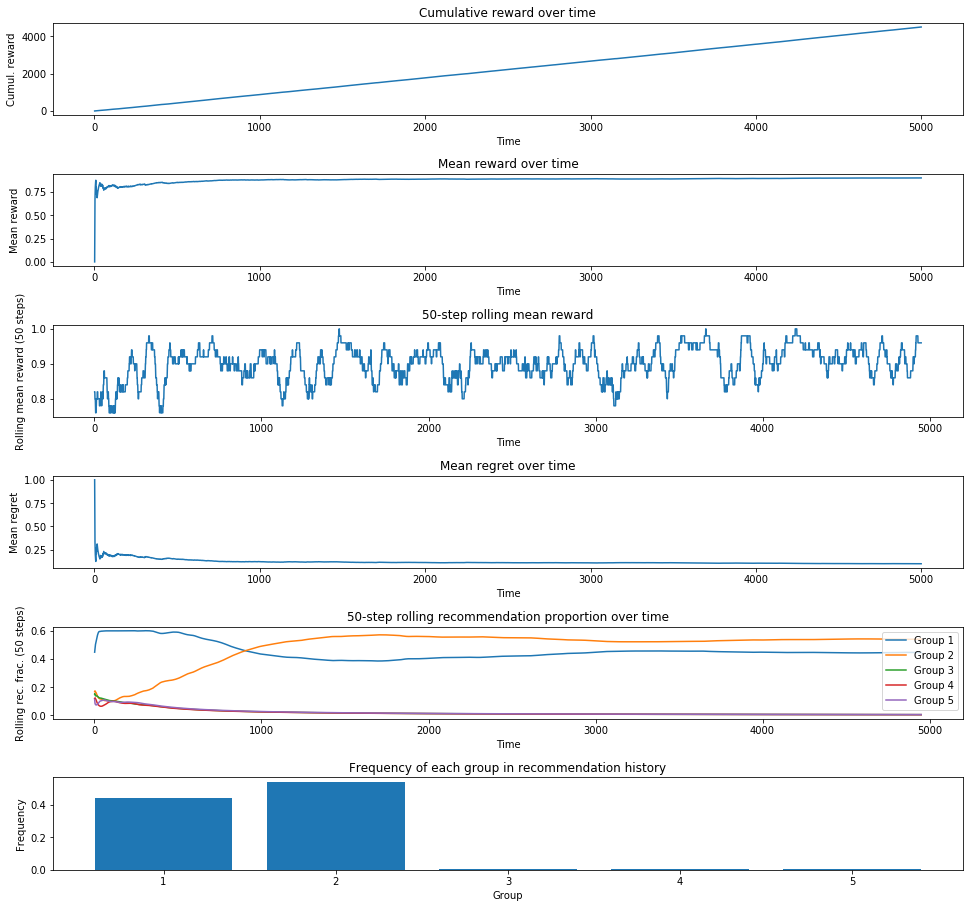

In [39]:
score(history_th3, n_arms = arms)

### Exp3

Group frequencies                 : [0.5884 0.3074 0.0284 0.029  0.0468]
Max gap between group frequencies : 0.56


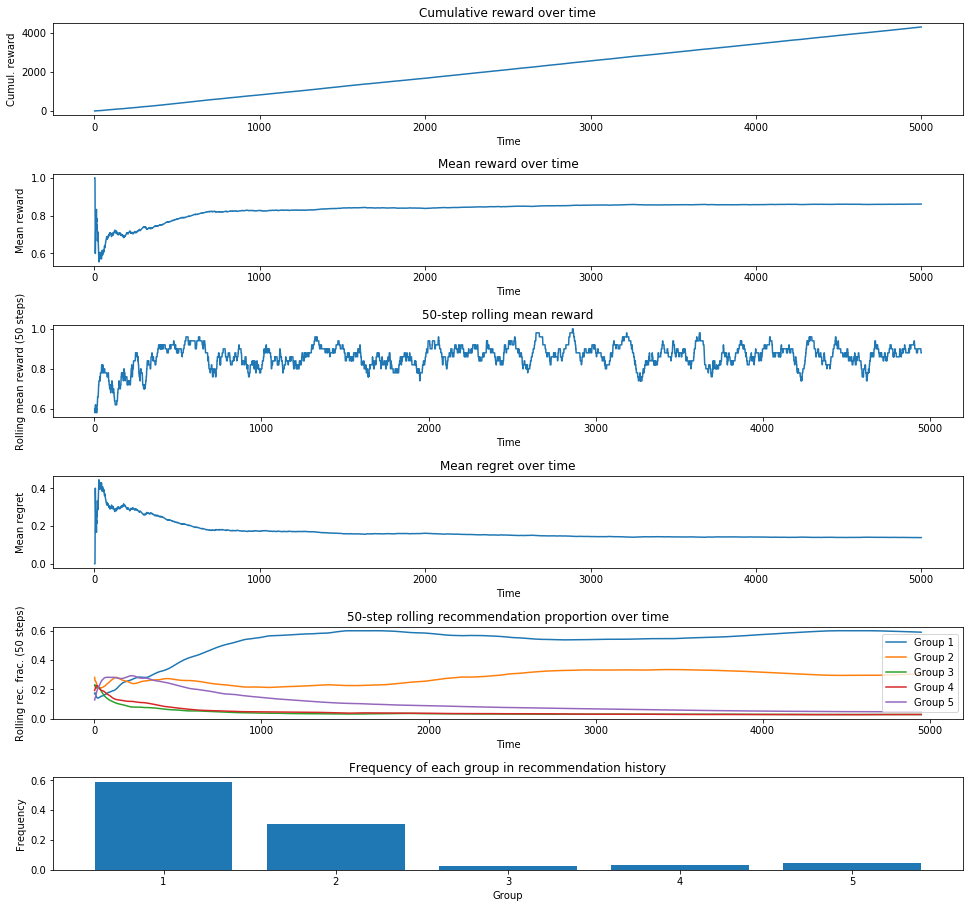

In [40]:
score(history_exp3_3, n_arms = arms)

# 2. Adding Constraints

# A UCB variant with fair group representations

----- Successfully trained Fair UCB Agent -----
Group frequencies                 : [0.5894 0.1026 0.1028 0.1026 0.1026]
Max gap between group frequencies : 0.4868


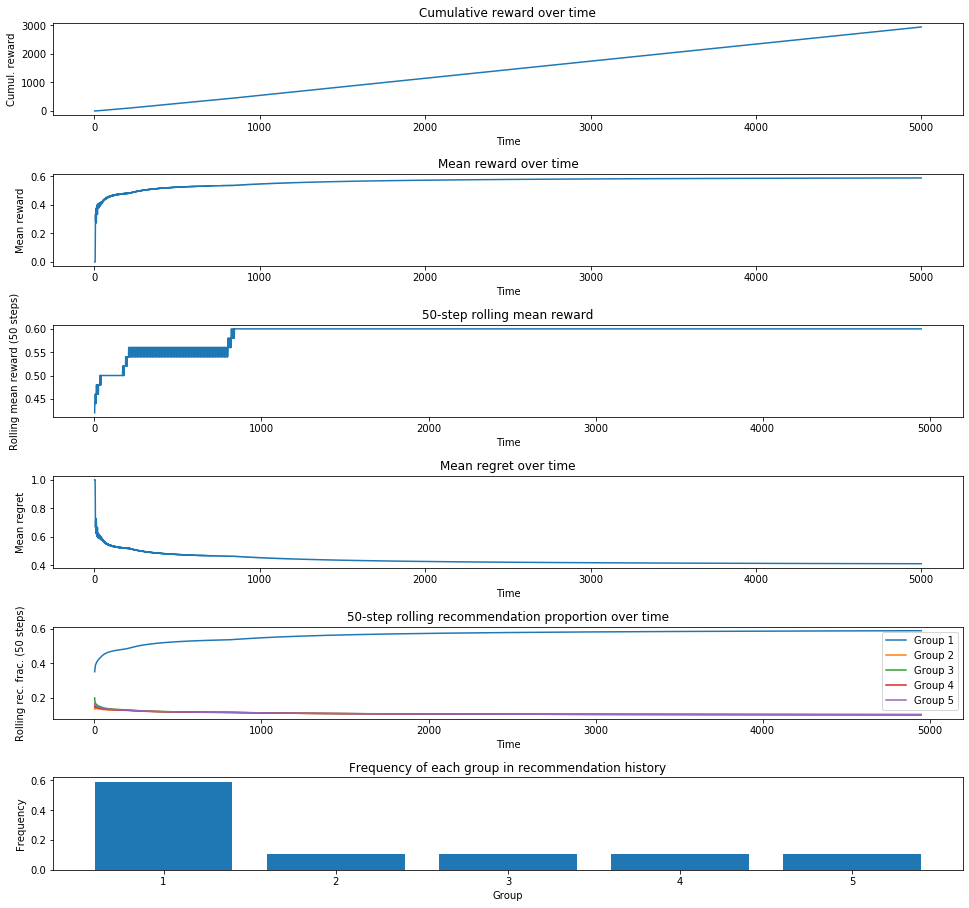

In [41]:
# Initialize agent
fairUCB = FairUCB(lower = 0.10)

# Train agent
fairHistory = train(user2, fairUCB, steps = rounds)

# Plot results
score(fairHistory, n_arms = arms)

# Combining lower and upper fairness constraints

----- Successfully trained Fair UCB Agent -----
Group frequencies                 : [0.5    0.1248 0.126  0.1258 0.1234]
Max gap between group frequencies : 0.3766


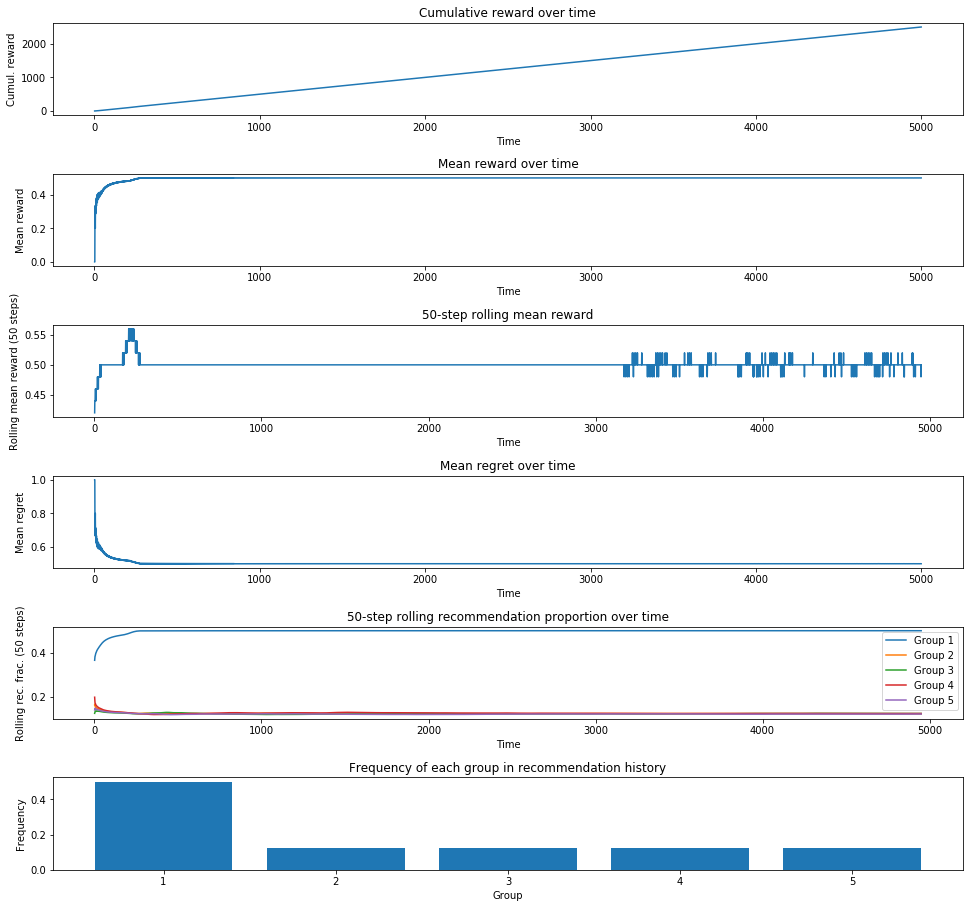

In [42]:
# Initialize agent
fairUCB2 = FairUCB(lower = 0.1, upper = 0.5)

# Train agent
fairHistory = train(user2, fairUCB2, steps = rounds)

# Plot results
score(fairHistory, n_arms = arms)

# 3. Fair-MAB